# CS224W - Colab 4

本次实验中，我们要将注意力从同构图转向异构图。异构图和我们之前见过的传统同构图不一样，它有多种结点类型和边类型。我们可以用这些额外信息来拓展我们之前的图神经网络模型，即基于异构图的消息传递。其中，不同类型的结点和边类型之间存在着不同的消息类型。

首先，我们要学习如何将 `NetworkX` 图转化为用 `DeepSNAP` 来表示。除此之外，我们还要深入理解 `DeepSNAP` 如何将异构图存储和表示成 `PyTorch` 张量的。

然后，我们要使用 `PyG` 和 `DeepSNAP` 来搭建一个用于结点分类任务的异构图神经网络。我们还使用异构的 ACM 数据集来评估我们的模型。

**注意**：确保顺序执行所有代码单元，否则变量或库无法在之后的单元中使用。实验愉快 ：）


> 在实验开始之前，请确保正确安装了 [PyG](https://pytorch-geometric.readthedocs.io/en/latest/notes/installation.html) 以及 [DeepSNAP](https://snap.stanford.edu/deepsnap/notes/installation.html) 第三方库。

In [1]:
import torch_geometric
torch_geometric.__version__

'2.0.4'

## 1 DeepSNAP 异构图

首先，我们来学习以下如何将 `NetworkX` 图转化为 `DeepSNAP` 支持的格式。

为了将传统的 `DeepSNAP` 图表征技术拓展到可以表征异构图，我们加上以下几个图特征：

- `node_feature`：结点的特征 `torch.tensor`
- `edge_feature`：边的特征 `torch.tensor`
- `node_label`：结点的标签 `int`
- `node_type`：结点类型 `string`
- `edge_type`：边类型 `string`

在新加入的这几个特征之中，最关键的是 `node_type` 和 `edge_type`，它们将指导如何进行消息传递。

在第一个问题中，我们将使用熟悉的 [karate club graph](https://networkx.github.io/documentation/stable/auto_examples/graph/plot_karate_club.html)。由于结点属于 `Mr.Hi` 和 `Officer` 这两种俱乐部其中的一种，我们便将结点的 `club` 属性当成 `node_type`。以下代码展示了如何区分 `NetworkX` 图中的结点。

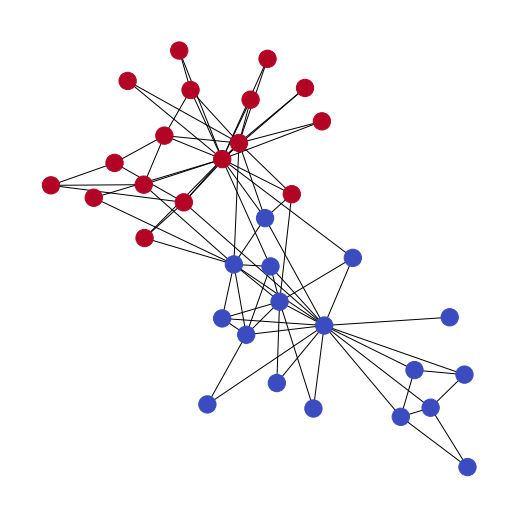

In [2]:
from pylab import *
import networkx as nx
from networkx.algorithms.community import greedy_modularity_communities
import matplotlib.pyplot as plt
import copy

G = nx.karate_club_graph()
community_map = {}
for node, club in G.nodes(data="club"):
  if club == "Mr. Hi":
    community_map[node] = 0
  else:
    community_map[node] = 1
node_color = []
color_map = {0: 0, 1: 1}
node_color = [color_map[community_map[node]] for node in G.nodes()]
pos = nx.spring_layout(G)
plt.figure(figsize=(7, 7))
nx.draw(G, pos=pos, cmap=plt.get_cmap('coolwarm'), node_color=node_color)
show()

### 问题 1.1: 分配结点类型和结点特征

使用 `community_map` 字典和上边的图 `G`，在图 `G` 中加入结点类型和结点标签。即给 `"Mr. Hi"` 俱乐部的结点的 `node_type` 赋值为 `n0`，给 `"Officer"` 俱乐部的结点的 `node_type` 赋值为 `n1`。

至于 `node_label`，`"Mr. Hi"` 中结点的 `node_label` 赋值为 `0`，`"Officer"` 中结点赋值为 `1`。

最后，给每个结点的特征都赋值为 `[1, 1, 1, 1, 1]`。

**提示**：看一看 `NetworkX` 的函数 `nx.classes.function.set_node_attributes`。

**注意**：这个问题对于后续问题很重要，请确保正确实现。

In [3]:
import torch
from typing import Dict

def assign_node_types(G: nx.Graph, community_map: Dict[int, int]):
  # TODO: Implement this function that takes in a NetworkX graph
  # G and community map assignment (mapping node ids --> 0/1 labels)
  # and adds 'node_type' as a node_attribute in G.

  node_type = {node: "n0" if community_map[node] == 0 else "n1" for node in G.nodes()}
  nx.set_node_attributes(G, node_type, "node_type")

def assign_node_labels(G: nx.Graph, community_map: Dict[int, int]):
  # TODO: Implement this function that takes in a NetworkX graph
  # G and community map assignment (mapping node ids --> 0/1 labels)
  # and adds 'node_label' as a node_attribute in G.

  node_label = {node: 0 if community_map[node] == 0 else 1 for node in G.nodes()}
  nx.set_node_attributes(G, node_label, "node_label")

def assign_node_features(G: nx.Graph):
  # TODO: Implement this function that takes in a NetworkX graph
  # G and adds 'node_feature' as a node_attribute in G. Each node
  # in the graph has the same feature vector [1., 1., 1., 1., 1.]

  node_features = {node: [1., 1., 1., 1., 1.] for node in G.nodes()}
  nx.set_node_attributes(G, node_features, "node_features")

assign_node_types(G, community_map)
assign_node_labels(G, community_map)
assign_node_features(G)

### 问题 1.2: 分配边类型

下一步，我们给边分配三种 `edge_type`：

- `Mr. Hi` 内部的边类型：`e0`
- `Officer` 内部的边类型：`e1`
- 两个俱乐部之间的边类型：`e2`

**提示**：使用之前的 `community_map` 和 `nx.classes.function.set_edge_attrbutes`。

In [4]:
def assign_edge_types(G: nx.Graph, community_map: Dict[int, int]):
  # TODO: Implement this function that takes in a NetworkX graph
  # G and community map assignment (mapping node ids --> 0/1 labels)
  # and adds 'edge_type' as a edge_attribute in G.

  edge_type = dict()
  for u, v in G.edges():
    edge_type[(u, v)] = f"e{community_map[u]}" if community_map[u] == community_map[v] else "e2"
  nx.set_edge_attributes(G, edge_type, "edge_type")

assign_edge_types(G, community_map)

### 异构图可视化

现在我们来可视化刚生成的异构图。其中有俱乐部内部边（2种）以及俱乐部之间的边（1种）。不同类型的结点和边用不同颜色来区分。下面的 `NetworkX` 对象 `G` 可以直接转换成 `deepsnap.hetero_graph.HeteroGraph` 对象。

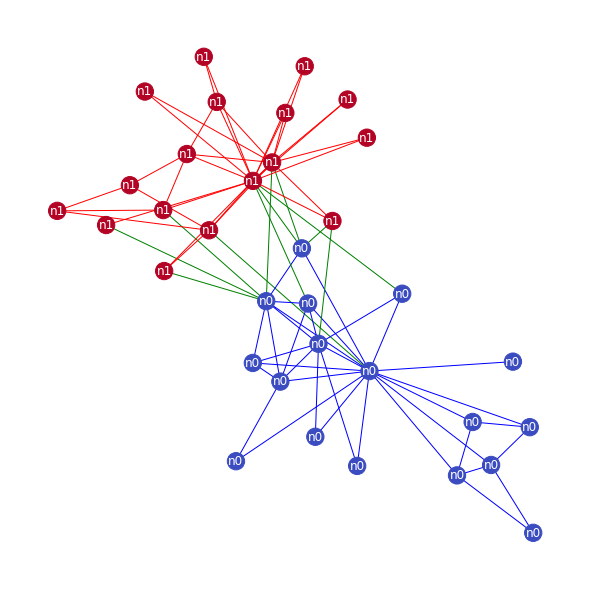

In [5]:
edge_color = {}
for edge in G.edges():
  n1, n2 = edge
  if community_map[n1] == community_map[n2] and community_map[n1] == 0:
    edge_color[edge] = 'blue'
  elif community_map[n1] == community_map[n2] and community_map[n1] == 1:
    edge_color[edge] = 'red'
  else:
    edge_color[edge] = 'green'

G_orig = copy.deepcopy(G)
nx.classes.function.set_edge_attributes(G, edge_color, name='color')
colors = nx.get_edge_attributes(G,'color').values()
labels = nx.get_node_attributes(G, 'node_type')
plt.figure(figsize=(8, 8))
nx.draw(G, pos=pos, cmap=plt.get_cmap('coolwarm'), node_color=node_color, edge_color=colors, labels=labels, font_color='white')
show()

### 转换为 `DeepSNAP` 表征

下列代码种的 `NetworkX` 对象 `G` 可以直接转换为 `deepsnap.hetero_graph.HeteroGraph` 对象！

In [6]:
from deepsnap.hetero_graph import HeteroGraph

hete = HeteroGraph(G_orig)

### 问题 1.3: 不同结点类型的结点各有多少？

In [7]:
def get_nodes_per_type(hete: HeteroGraph):
  # TODO: Implement this function that takes a DeepSNAP dataset object
  # and return the number of nodes per `node_type`.

  num_nodes_n0, num_nodes_n1 = hete.num_nodes(["n0", "n1"]).values()
  return num_nodes_n0, num_nodes_n1

num_nodes_n0, num_nodes_n1 = get_nodes_per_type(hete)
print(f"Node type n0 has {num_nodes_n0} nodes")
print(f"Node type n1 has {num_nodes_n1} nodes")

Node type n0 has 17 nodes
Node type n1 has 17 nodes


### 问题 1.4: 不同消息类型的消息各有多少？

我们现在讨论的是异构的消息类型（即不同 `node_type` 和 `edge_type` 组合的消息类型）。比如，用 `e0` 类型连接的两个 `"Mr.Hi"` 结点是一种消息类型，即 (`n0`, `e0`, `n0`) 类型。在本问题中，我们要分析每种类型各有多少边。

**提示**：如果你想要了解更多不同消息类型，试试调用 `hete.message_types`。

In [8]:
def get_num_message_edges(hete: HeteroGraph):
  # TODO: Implement this function that takes a DeepSNAP dataset object
  # and return the number of edges for each message type. 
  # You should return a list of tuples as 
  # (message_type, num_edge)

  message_type_edges = [(msg_t, n_edge) for msg_t, n_edge in hete.num_edges().items()]
  return message_type_edges

message_type_edges = get_num_message_edges(hete)
for (message_type, num_edges) in message_type_edges:
  print(f"Message type {message_type} has {num_edges} edges")


Message type ('n0', 'e0', 'n0') has 35 edges
Message type ('n0', 'e2', 'n1') has 11 edges
Message type ('n1', 'e1', 'n1') has 32 edges


### 问题 1.5: 不同数据集分割中各有多少结点？

`DeepSNAP` 中有异构图的数据集创建和分割方法。我们在这里创建用来结点分类的训练集、验证集，以及测试集，并观察一下分割后的子图。具体点就是写一个函数来计算不同数据集分割中的结点个数。

In [9]:
from deepsnap.dataset import GraphDataset
from functools import reduce


def compute_dataset_split_counts(datasets: Dict[str, GraphDataset]):
  # TODO: Implement this function that takes a dict of datasets
  # and returns a dict mapping dataset names to the number of labeled
  # nodes used for supervision in that respective dataset.  
  dataset_splits = {
    name: reduce(lambda a, b: a + b, map(lambda t: t.shape[0], dataset[0].node_label_index.values()), 0)
    for name, dataset in datasets.items()
  }
  return dataset_splits


dataset = GraphDataset([hete], task='node')
# Splitting the dataset
dataset_train, dataset_val, dataset_test = dataset.split(transductive=True, split_ratio=[0.4, 0.3, 0.3])
datasets = {'train': dataset_train, 'val': dataset_val, 'test': dataset_test}

data_set_splits = compute_dataset_split_counts(datasets)
for dataset_name, num_nodes in data_set_splits.items():
  print(f"{dataset_name} dataset has {num_nodes} nodes")

train dataset has 12 nodes
val dataset has 10 nodes
test dataset has 12 nodes


### `DeepSNAP` 数据集可视化

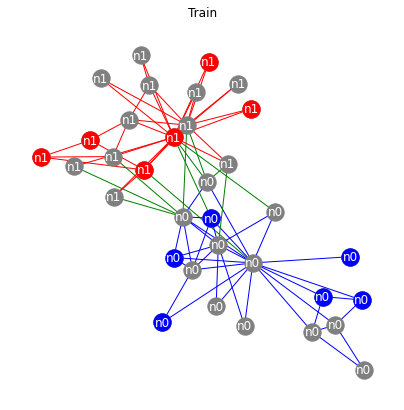

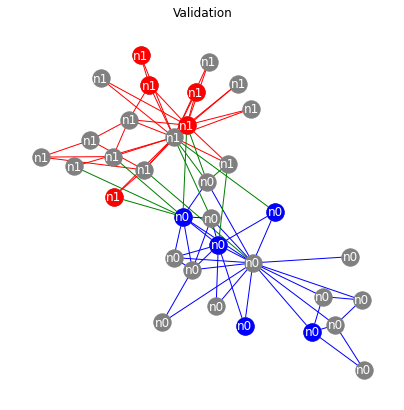

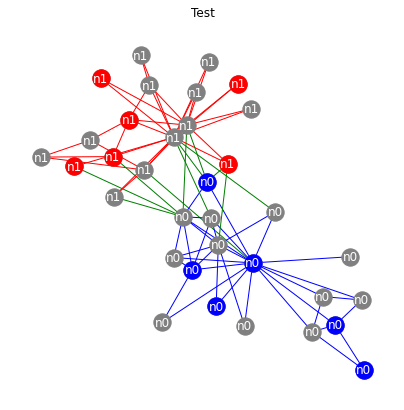

In [10]:
from deepsnap.dataset import GraphDataset

dataset = GraphDataset([hete], task='node')
# Splitting the dataset
dataset_train, dataset_val, dataset_test = dataset.split(transductive=True, split_ratio=[0.4, 0.3, 0.3])
titles = ['Train', 'Validation', 'Test']

for i, dataset in enumerate([dataset_train, dataset_val, dataset_test]):
  n0 = hete._convert_to_graph_index(dataset[0].node_label_index['n0'], 'n0').tolist()
  n1 = hete._convert_to_graph_index(dataset[0].node_label_index['n1'], 'n1').tolist()

  plt.figure(figsize=(7, 7))
  plt.title(titles[i])
  nx.draw(G_orig, pos=pos, node_color="grey", edge_color=colors, labels=labels, font_color='white')
  nx.draw_networkx_nodes(G_orig.subgraph(n0), pos=pos, node_color="blue")
  nx.draw_networkx_nodes(G_orig.subgraph(n1), pos=pos, node_color="red")
  show()

## 2 异构图结点分类

这一部分中我们将使用 `PyG` 和 `DeepSNAP` 来实现一个用来给异构图进行结点分类的 GNN 模型。本部分内容要求你对异构图有较好的理解，并熟悉如何使用 `PyG` 来实现一个 GNN 层。

首先我们来看看异构层的一般结构。假设我们有一张图 $G$，其中由两种结点 $a$ 和 $b$，三种消息类型 $m_1=(a, r_1, a)$，$m_2=(a, r_2, b)$ 以及 $m_3=(a, r_3, b)$。

因此，对于图 $G$ 而言，一个异构层会有三个异构 GNN 层（即本实验中的 `HeteroGNNConv`），其中每个 `HeteroGNNConv` 层都会针对一种消息类型进行消息传递与聚合。异构层概览如下：

<br/>
<center>
<img src="assets/hetero_conv.png"/>
</center>
<br/>

本实验中，所有 $l^\text{th}$ 的异构 GNN 层（`HeteroGNNConv`）都由 $l^\text{th}$ 的异构 GNN 包装器层（`HeteroGNNWrapperConv`）管理。$l^\text{th}$ 异构 GNN 包装器层会接收前一层输出的结点嵌入作为输入，并用不同的异构 GNN 层在不同消息类型间进行消息传递与聚合。比如，结点 $b$ 的嵌入就是包装器层聚合两个异构 GNN 层的结果，一个用来传播 $m_2$，一个用来传播 $m_3$。简化过的异构层结构如下：

<br/>
<center>
<img src="assets/hetero_conv_1.png"/>
</center>
<br/>

<font color='red'>推荐你按如下步骤实现异构GNN模型：</font>

1. 实现 `HeteroGNNConv` 层。
2. 实现 `HeteroGNNWrapperConv` 中的平均聚合（`mean`聚合）。
3. 实现 `generate_convs` 函数。
4. 实现 `HeteroGNN` 模型和 `train` 函数。
5. 用 `mean` 聚合训练模型聚合不同类型的消息，并确保模型性能合理。
6. 实现 `HeteroGNNWrapperConv` 中的注意力机制聚合（`attn` 聚合）。
7. 用 `attn` 聚合训练模型聚合不同类型的消息，并确保模型性能合理。

### 配置

In [11]:
import copy
import torch
import deepsnap
import numpy as np
import torch.nn as nn
import torch.nn.functional as F
import torch_geometric.nn as pyg_nn

from sklearn.metrics import f1_score
from deepsnap.hetero_gnn import forward_op
from deepsnap.hetero_graph import HeteroGraph
from torch_sparse import SparseTensor, matmul

### 异构 GNN 层

现在我们开始实现异构层（`HeteroGNNConv`）！与 Colab3 相似，我们还是使用 `PyG` 来搭建网络。总的来说，我们的异构 GNN 层从 **GraphSAGE** 中汲取了灵感([Hamilton et al. (2017)](https://arxiv.org/abs/1706.02216))。

首先，我们给如下每一种消息类型都实现一个 GNN 层：

$$
\begin{equation*}
m =(s, r, d)
\end{equation*}
$$

每种消息类型都是一个三元组，其中 $s$ 指源结点类型，$r$ 指边（关系）类型，$d$ 指目标结点类型。更新规则与 GraphSAGE 相似，但我们需要将不同的结点类型和边类型考虑在内，更新规则如下：

$$
\begin{equation*}
h_v^{(l)[m]} = W^{(l)[m]} \cdot \text{CONCAT} \left( W_d^{(l)[m]} \cdot h_v^{(l-1)}, W_s^{(l)[m]} \cdot \text{AGG}\left(\left\{h_u^{(l-1)}, \forall u \in N_{m}(v) \right\}\right)\right)
\end{equation*}
$$

其中 $[m]$ 指关于消息类型 $m$ 的权重矩阵或嵌入，$W_s^{(l)[m]}$ 用来计算来自邻居结点的消息，$W_d^{(l)[m]}$ 计算自己的消息，$W^{(l)[m]}$ 将两种结点类型的消息聚合。

在上述等式中，$v$ 的结点类型是 $d$，$u$ 的结点类型是 $s$。简单起见，我们这里先用平均聚合作为 $\text{AGG}$：

$$
\begin{equation*}
AGG(\{h_u^{(l-1)}, \forall u \in N_{m}(v) \}) = \frac{1}{|N_{m}(v)|} \sum_{u\in N_{m}(v)} h_u^{(l-1)}
\end{equation*}
$$

> 译者注：最终，如果写成矩阵乘法的形式（聚合方式为平均聚合），则公式如下：
>
> $$
> \text{CONCAT} \left( H^{(l-1)} W^{(l)[m]}_\text{d}, D^{-1} A H^{(l-1)} W^{(l)[m]}_\text{s} \right) W^{(l)[m]}
> $$
> 
> 其中，$D$ 是度矩阵，$A$ 为 $m$ 类型关系的邻接矩阵。

In [12]:
class HeteroGNNConv(pyg_nn.MessagePassing):
    def __init__(self, in_channels_src, in_channels_dst, out_channels):
        super(HeteroGNNConv, self).__init__(aggr="mean")

        self.in_channels_src = in_channels_src
        self.in_channels_dst = in_channels_dst
        self.out_channels = out_channels

        # To simplify implementation, please initialize both self.lin_dst
        # and self.lin_src out_features to out_channels
        self.lin_dst = nn.Linear(in_channels_dst, out_channels)
        self.lin_src = nn.Linear(in_channels_src, out_channels)
        # the input of self.lin_update is the concatenation of two messages
        self.lin_update = nn.Linear(2 * out_channels, out_channels)


    def forward(self, node_feature_src, node_feature_dst, edge_index, size=None, res_n_id=None):
        return self.propagate(
            edge_index=edge_index,
            size=size,
            node_feature_src=self.lin_src(node_feature_src),
            node_feature_dst=self.lin_dst(node_feature_dst),
            res_n_id=res_n_id
            )

    def message_and_aggregate(self, edge_index, node_feature_src):
        # Computes the mean aggregation of neighboring nodes, i.e. D^{-1}AH^{(l-1)}W^{(l)}_s,
        return matmul(edge_index, node_feature_src, self.aggr)

    def update(self, aggr_out, node_feature_dst, res_n_id):
        concat = torch.concat([node_feature_dst, aggr_out], dim=-1)
        return self.lin_update(concat)

### 异构 GNN 包装器

在给每一种消息类型都实现 GNN 层之后，我们需要将消息关于类型聚合起来，这里我们将实现两种消息级别的聚合。

第一种就是简单的平均聚合：

$$
\begin{equation*}
h_v^{(l)} = \frac{1}{M}\sum_{m=1}^{M}h_v^{(l)[m]}
\end{equation*}
$$

这里的结点 $v$ 的类型是 $d$，$M$ 是目标结点类型为 $d$ 的消息类型总数。

另一种就是 **HAN** 中（[Wang et al. (2019)](https://arxiv.org/abs/1903.07293)）引入的语义级别注意力机制。与之前直接平均不一样，我们使用注意力机制来学习哪一种消息类型结果会重要，然后再聚合所有的消息类型。下列等式就是语义级别的注意力机制：

$$
\begin{equation*}
e_{m} = \frac{1}{|V_{d}|} \sum_{v \in V_{d}} q_\text{attn}^T \cdot \tanh \left( W_\text{attn}^{(l)} \cdot h_v^{(l)[m]} + b \right)
\end{equation*}
$$

其中 $m$ 指消息类型，$d$ 指目标结点类型。然后我们就可以计算注意力机制，并更新 $h_v^{(l)}$：

$$
\begin{equation*}
\alpha_{m} = \frac{\exp(e_{m})}{\sum_{m=1}^M \exp(e_{m})}
\end{equation*}
$$

$$
\begin{equation*}
h_v^{(l)} = \sum_{m=1}^{M} \alpha_{m} \cdot h_v^{(l)[m]}
\end{equation*}
$$

In [13]:
from torch import Tensor
from typing import List, Tuple
from torch_geometric.typing import Adj


class HeteroGNNWrapperConv(deepsnap.hetero_gnn.HeteroConv):
    def __init__(self, convs, args, aggr="mean"):
        super(HeteroGNNWrapperConv, self).__init__(convs, None)
        self.aggr = aggr

        # Map the index and message type
        self.mapping = {}

        # A numpy array that stores the final attention probability
        self.alpha = None

        self.attn_proj = None

        if self.aggr == "attn":
            self.attn_proj = nn.Sequential(
                nn.Linear(args["hidden_size"], args["attn_size"], bias=True),
                nn.Tanh(),
                nn.Linear(args["attn_size"], 1, bias=False)
            )
    
    def reset_parameters(self):
        super(HeteroGNNWrapperConv, self).reset_parameters()
        if self.aggr == "attn":
            for layer in self.attn_proj.children():
                layer.reset_parameters()
    
    def forward(self, node_features, edge_indices: Dict[Tuple[str, str, str], Adj]):
        ############################# Step 1 ############################
        # Use different convolution layers for different message types. #
        # Store the final in a dict whose key is message type triplet.  #
        ############################# Step 1 ############################
        message_type_emb = {}
        for message_key, edge_index in edge_indices.items():
            src_type, edge_type, dst_type = message_key
            node_feature_src = node_features[src_type]
            node_feature_dst = node_features[dst_type]
            message_type_emb[message_key] = (
                self.convs[message_key](
                    node_feature_src,
                    node_feature_dst,
                    edge_index,
                )
            )
                                                                        
        ############################ Step 2 ############################
        # Store the results in node_emb, which can be indexed with dst #
        # node type.                                                   #
        ################################################################
        node_emb = {dst: [] for _, _, dst in message_type_emb.keys()}
        # mapping/self.mapping 没看出来有什么卵用
        mapping = {}
        for (src, edge_type, dst), emb_mat in message_type_emb.items():
            mapping[len(node_emb[dst])] = (src, edge_type, dst)
            node_emb[dst].append(emb_mat)
        self.mapping = mapping

        ############################ Step 3 ############################
        # aggregate the convolution results based on dst node type.    #
        ################################################################
        for node_type, embs in node_emb.items():
            if len(embs) == 1:
                node_emb[node_type] = embs[0]
            else:
                node_emb[node_type] = self.aggregate(embs)
        return node_emb
    
    def aggregate(self, xs: List[Tensor]):
        # TODO: Implement this function that aggregates all message type results.
        # Here, xs is a list of tensors (embeddings) with respect to message 
        # type aggregation results.

        if self.aggr == "mean":
            return torch.stack(xs, dim=0).mean(dim=0)

        elif self.aggr == "attn":
            # Stack embeddings of different message types
            xs: Tensor = torch.stack(xs, dim=0)
            # M (#message types) * N (#nodes)
            attns: Tensor = self.attn_proj(xs).squeeze(-1)
            # average & normalize the attention weight, shape: M
            attns = attns.mean(dim=1).softmax(dim=0)
            # record the attention for visualization
            self.alpha = attns.detach().cpu().numpy()
            return (attns.view(-1, 1, 1) * xs).sum(dim=0)

### 初始化异构 GNN 层

现在我们来初始化异构 GNN 层。与同构图不同，异构图有些难。

总体而言，我们需要创建一个字典的 `HeteroGNNConv` 层，键为消息类型。

- 想要获取所有的消息类型？`deepsnap.hetero_graph.HeteroGraph.message_types`会有帮助。
- 如果我们初始化的**是第一个**卷积层，我们得要知道每种结点类型的特征维度。使用 `deepsnap.hetero_graph.HeteroGraph.num_node_features(node_type)` 能获取 `node_type` 类型结点的特征维度。
- 如果我们初始化的**不是第一个**卷积层，所有结点类型都由一样的嵌入大小 `hidden_size`。
- 无论初始化的是第一个卷积层与否，我们都将 `HeteroGNNConv` 的 `out_channels` 设置成 `hidden_size`。

In [14]:
def generate_convs(hetero_graph: HeteroGraph, conv, hidden_size: int, first_layer=False):
    # TODO: Implement this function that returns a dictionary of `HeteroGNNConv`
    # layers where the keys are message types. `hetero_graph` is deepsnap `HeteroGraph`
    # object and the `conv` is the `HeteroGNNConv`.

    if not first_layer:
        convs = {msg_t: conv(hidden_size, hidden_size, hidden_size)
                 for msg_t in hetero_graph.message_types}
        return convs

    convs = {}
    for src_t, edge_t, dst_t in hetero_graph.message_types:
        convs[(src_t, edge_t, dst_t)] = conv(
            hetero_graph.num_node_features(src_t),
            hetero_graph.num_node_features(dst_t),
            hidden_size
        )
    return convs

### `HeteroGNN`

现在我们来写一个只有两层 `HeteroGNNWrapperConv` 的简单 `HeteroGNN` 模型。

`HeteroGNN` 中的 `forward` 方法会按照如下运行：

$\text{self.convs1} \rightarrow \text{self.bns1} \rightarrow \text{self.relus1} \rightarrow \text{self.convs2} \rightarrow \text{self.bns2} \rightarrow \text{self.relus2} \rightarrow \text{self.post\_mps}$

In [15]:
class HeteroGNN(torch.nn.Module):
    def __init__(self, hete: HeteroGraph, args, aggr="mean"):
        super(HeteroGNN, self).__init__()

        self.aggr = aggr
        self.hidden_size = args['hidden_size']

        convs = generate_convs(hete, HeteroGNNConv, self.hidden_size, True)
        self.convs1 = HeteroGNNWrapperConv(convs, args, aggr=self.aggr)
        convs = generate_convs(hete, HeteroGNNConv, self.hidden_size)
        self.convs2 = HeteroGNNWrapperConv(convs, args, aggr=self.aggr)

        self.bns1 = nn.ModuleDict()
        self.bns2 = nn.ModuleDict()
        self.relus1 = nn.ModuleDict()
        self.relus2 = nn.ModuleDict()
        self.post_mps = nn.ModuleDict()
        for node_t in hete.node_types:
            self.bns1[node_t] = nn.BatchNorm1d(self.hidden_size, eps=1.0)
            self.bns2[node_t] = nn.BatchNorm1d(self.hidden_size, eps=1.0)
            self.relus1[node_t] = nn.LeakyReLU()
            self.relus2[node_t] = nn.LeakyReLU()
            self.post_mps[node_t] = nn.Linear(self.hidden_size, hete.num_node_labels(node_t))

    def forward(self, node_feature: Dict[str, Tensor], edge_index: Dict[Tuple[str, str, str], Tensor]):
        # TODO: Implement the forward function. Notice that `node_feature` is
        # a dictionary of tensors where keys are node types and values are
        # corresponding feature tensors. The `edge_index` is a dictionary of
        # tensors where keys are message types and values are corresponding
        # edge index tensors (with respect to each message type).

        x = node_feature
        x = self.convs1(x, edge_index)
        x = forward_op(x, self.bns1)
        x = forward_op(x, self.relus1)
        x = self.convs2(x, edge_index)
        x = forward_op(x, self.bns2)
        x = forward_op(x, self.relus2)
        x = forward_op(x, self.post_mps)
        return x

    def loss(self, preds: Dict[str, Tensor], y: Dict[str, Tensor], indices):

        loss = 0
        loss_func = F.cross_entropy

        for node_t, pred in preds.items():
            index = indices[node_t]
            loss += loss_func(pred[index], y[node_t][index])

        return loss


### 训练并测试

现在我们给你提供了用来训练和测试的函数，你只需要实现一行代码。

In [16]:
def train(model, optimizer, hetero_graph: HeteroGraph, train_idx):
    model.train()
    optimizer.zero_grad()
    preds = model(hetero_graph.node_feature, hetero_graph.edge_index)
    loss = model.loss(preds, hetero_graph.node_label, train_idx)
    loss.backward()
    optimizer.step()
    return loss.item()

def test(model, graph, indices, best_model=None, best_val=0):
    model.eval()
    accs = []
    for index in indices:
        preds = model(graph.node_feature, graph.edge_index)
        num_node_types = 0
        micro = 0
        macro = 0
        for node_type in preds:
            idx = index[node_type]
            pred = preds[node_type][idx]
            pred = pred.max(1)[1]
            label_np = graph.node_label[node_type][idx].cpu().numpy()
            pred_np = pred.cpu().numpy()
            micro = f1_score(label_np, pred_np, average='micro')
            macro = f1_score(label_np, pred_np, average='macro')
            num_node_types += 1
        # Averaging f1 score might not make sense, but in our example we only
        # have one node type
        micro /= num_node_types
        macro /= num_node_types
        accs.append((micro, macro))
    if accs[1][0] > best_val:
        best_val = accs[1][0]
        best_model = copy.deepcopy(model)
    return accs, best_model, best_val

In [17]:
# Please do not change the following parameters
args = {
    'device': torch.device('cuda' if torch.cuda.is_available() else 'cpu'),
    'hidden_size': 64,
    'epochs': 100,
    'weight_decay': 1e-5,
    'lr': 0.003,
    'attn_size': 32,
}

### 数据集和预处理

下一步，我们要加载数据集并创建张量后端（不使用 `NetworkX` 图）`deepsnap.hetero_graph.HeteroGraph` 对象。

然后使用 **HAN**（[Wang et al. (2019)](https://arxiv.org/abs/1903.07293)）中提出的任务，即使用 `ACM(3025)` 数据集进行结点分类任务，我们的数据集是抽取自 [DGL](https://www.dgl.ai/) 的 [ACM.mat](https://data.dgl.ai/dataset/ACM.mat)。

最初的 ACM 数据集有三种结点类型和两个边（关系）类型。简单起见，我们使用一种如下所示的结点类型和两种边类型的异构图。这意味着在我们的异构图中，我们只有一种结点类型（$\text{paper}$）和两种消息类型（$(\text{paper}\xrightarrow{\text{author}}\text{paper})$ 和 $(\text{paper}\xrightarrow{\text{subject}}\text{paper})$）。

<br/>
<center>
<img src="assets/cs224w-acm.png"/>
</center>


In [18]:
print(f"Device: {args['device']}")

# Load the data
data = torch.load("dataset/acm.pkl")

# Message types
message_type_1 = ("paper", "author", "paper")
message_type_2 = ("paper", "subject", "paper")

# Dictionary of edge indices
edge_index = {}
edge_index[message_type_1] = data['pap']
edge_index[message_type_2] = data['psp']

# Dictionary of node features
node_feature = {}
node_feature["paper"] = data['feature']

# Dictionary of node labels
node_label = {}
node_label["paper"] = data['label']

# Load the train, validation and test indices
train_idx = {"paper": data['train_idx'].to(args['device'])}
val_idx = {"paper": data['val_idx'].to(args['device'])}
test_idx = {"paper": data['test_idx'].to(args['device'])}

# Construct a deepsnap tensor backend HeteroGraph
hetero_graph = HeteroGraph(
    node_feature=node_feature,
    node_label=node_label,
    edge_index=edge_index,
    directed=True
)

print(f"ACM heterogeneous graph: {hetero_graph.num_nodes()} nodes, {hetero_graph.num_edges()} edges")

# Node feature and node label to device
for key in hetero_graph.node_feature:
    hetero_graph.node_feature[key] = hetero_graph.node_feature[key].to(args['device'])
for key in hetero_graph.node_label:
    hetero_graph.node_label[key] = hetero_graph.node_label[key].to(args['device'])

# Edge_index to sparse tensor and to device
for key in hetero_graph.edge_index:
    edge_index = hetero_graph.edge_index[key]
    adj = SparseTensor(row=edge_index[0], col=edge_index[1], sparse_sizes=(hetero_graph.num_nodes('paper'), hetero_graph.num_nodes('paper')))
    hetero_graph.edge_index[key] = adj.t().to(args['device'])
print(hetero_graph.edge_index[message_type_1])
print(hetero_graph.edge_index[message_type_2])

Device: cuda
ACM heterogeneous graph: {'paper': 3025} nodes, {('paper', 'author', 'paper'): 26256, ('paper', 'subject', 'paper'): 2207736} edges
SparseTensor(row=tensor([   0,    0,    0,  ..., 3024, 3024, 3024], device='cuda:0'),
             col=tensor([   8,   20,   51,  ..., 2948, 2983, 2991], device='cuda:0'),
             size=(3025, 3025), nnz=26256, density=0.29%)
SparseTensor(row=tensor([   0,    0,    0,  ..., 3024, 3024, 3024], device='cuda:0'),
             col=tensor([  75,  434,  534,  ..., 3020, 3021, 3022], device='cuda:0'),
             size=(3025, 3025), nnz=2207736, density=24.13%)


### 训练平均聚合

In [19]:
best_model = None
best_val = 0

model = HeteroGNN(hetero_graph, args, aggr="mean").to(args['device'])
optimizer = torch.optim.Adam(model.parameters(), lr=args['lr'], weight_decay=args['weight_decay'])

for epoch in range(args['epochs']):
    loss = train(model, optimizer, hetero_graph, train_idx)
    accs, best_model, best_val = test(model, hetero_graph, [train_idx, val_idx, test_idx], best_model, best_val)
    print(
        f"Epoch {epoch + 1}: loss {round(loss, 5)}, "
        f"train micro {round(accs[0][0] * 100, 2)}%, train macro {round(accs[0][1] * 100, 2)}%, "
        f"valid micro {round(accs[1][0] * 100, 2)}%, valid macro {round(accs[1][1] * 100, 2)}%, "
        f"test micro {round(accs[2][0] * 100, 2)}%, test macro {round(accs[2][1] * 100, 2)}%"
    )
best_accs, _, _ = test(best_model, hetero_graph, [train_idx, val_idx, test_idx])
print(
    f"Best model: "
    f"train micro {round(best_accs[0][0] * 100, 2)}%, train macro {round(best_accs[0][1] * 100, 2)}%, "
    f"valid micro {round(best_accs[1][0] * 100, 2)}%, valid macro {round(best_accs[1][1] * 100, 2)}%, "
    f"test micro {round(best_accs[2][0] * 100, 2)}%, test macro {round(best_accs[2][1] * 100, 2)}%"
)

Epoch 1: loss 1.10054, train micro 33.33%, train macro 16.67%, valid micro 33.33%, valid macro 16.67%, test micro 32.89%, test macro 16.5%
Epoch 2: loss 1.09017, train micro 59.83%, train macro 50.33%, valid micro 58.67%, valid macro 49.36%, test micro 52.38%, test macro 42.99%
Epoch 3: loss 1.06172, train micro 77.5%, train macro 76.51%, valid micro 71.0%, valid macro 69.6%, test micro 55.58%, test macro 52.5%
Epoch 4: loss 1.00333, train micro 73.83%, train macro 69.51%, valid micro 71.33%, valid macro 66.45%, test micro 66.16%, test macro 57.93%
Epoch 5: loss 0.90301, train micro 70.67%, train macro 63.78%, valid micro 69.33%, valid macro 61.5%, test micro 65.65%, test macro 55.81%
Epoch 6: loss 0.75569, train micro 71.17%, train macro 64.47%, valid micro 69.0%, valid macro 60.77%, test micro 65.69%, test macro 55.2%
Epoch 7: loss 0.57763, train micro 71.33%, train macro 64.73%, valid micro 69.33%, valid macro 61.73%, test micro 65.84%, test macro 55.21%
Epoch 8: loss 0.40987, train

#### 问题 2.1: 使用平均聚合时，你用 `best_model` 在测试集上能获得的最大 **micro** F1 值是多少？

#### 问题 2.2: 使用平均聚合时，你用 `best_model` 在测试集上能获得的最大 **macro** F1 值是多少？

### 训练注意力聚合

In [20]:
best_model = None
best_val = 0

output_size = hetero_graph.num_node_labels('paper')
model = HeteroGNN(hetero_graph, args, aggr="attn").to(args['device'])
optimizer = torch.optim.Adam(model.parameters(), lr=args['lr'], weight_decay=args['weight_decay'])

for epoch in range(args['epochs']):
    loss = train(model, optimizer, hetero_graph, train_idx)
    accs, best_model, best_val = test(model, hetero_graph, [train_idx, val_idx, test_idx], best_model, best_val)
    print(
        f"Epoch {epoch + 1}: loss {round(loss, 5)}, "
        f"train micro {round(accs[0][0] * 100, 2)}%, train macro {round(accs[0][1] * 100, 2)}%, "
        f"valid micro {round(accs[1][0] * 100, 2)}%, valid macro {round(accs[1][1] * 100, 2)}%, "
        f"test micro {round(accs[2][0] * 100, 2)}%, test macro {round(accs[2][1] * 100, 2)}%"
    )
best_accs, _, _ = test(best_model, hetero_graph, [train_idx, val_idx, test_idx])
print(
    f"Best model: "
    f"train micro {round(best_accs[0][0] * 100, 2)}%, train macro {round(best_accs[0][1] * 100, 2)}%, "
    f"valid micro {round(best_accs[1][0] * 100, 2)}%, valid macro {round(best_accs[1][1] * 100, 2)}%, "
    f"test micro {round(best_accs[2][0] * 100, 2)}%, test macro {round(best_accs[2][1] * 100, 2)}%"
)

Epoch 1: loss 1.09902, train micro 33.33%, train macro 16.67%, valid micro 33.33%, valid macro 16.67%, test micro 32.89%, test macro 16.5%
Epoch 2: loss 1.08854, train micro 92.67%, train macro 92.78%, valid micro 88.67%, valid macro 88.9%, test micro 70.21%, test macro 70.96%
Epoch 3: loss 1.0555, train micro 74.33%, train macro 70.69%, valid micro 72.67%, valid macro 68.1%, test micro 64.42%, test macro 57.82%
Epoch 4: loss 0.99033, train micro 71.67%, train macro 65.22%, valid micro 70.0%, valid macro 62.32%, test micro 66.21%, test macro 55.76%
Epoch 5: loss 0.88316, train micro 69.5%, train macro 60.86%, valid micro 67.0%, valid macro 55.88%, test micro 65.32%, test macro 53.79%
Epoch 6: loss 0.74245, train micro 69.5%, train macro 61.19%, valid micro 67.67%, valid macro 57.24%, test micro 65.46%, test macro 54.06%
Epoch 7: loss 0.60034, train micro 70.67%, train macro 63.25%, valid micro 69.33%, valid macro 60.31%, test micro 65.74%, test macro 54.86%
Epoch 8: loss 0.478, train m

#### 问题 2.3: 使用注意力聚合时，你用 `best_model` 在测试集上能获得的最大 **micro** F1 值是多少？

#### 问题 2.4: 使用注意力聚合时，你用 `best_model` 在测试集上能获得的最大 **macro** F1 值是多少？

### 关于消息类型的注意力机制

通过消息类型等级的注意力机制，我们知道消息种类比来自消息来自哪一层更重要。

下面我们打印并说明了每一层中不同消息类型的注意力情况。

In [21]:
if model.convs1.alpha is not None and model.convs2.alpha is not None:
    for idx, message_type in model.convs1.mapping.items():
        print(f"Layer 1 has attention {model.convs1.alpha[idx]} on message type {message_type}")
    for idx, message_type in model.convs2.mapping.items():
        print(f"Layer 2 has attention {model.convs2.alpha[idx]} on message type {message_type}")

Layer 1 has attention 0.1556079387664795 on message type ('paper', 'author', 'paper')
Layer 1 has attention 0.8443920612335205 on message type ('paper', 'subject', 'paper')
Layer 2 has attention 0.7368417978286743 on message type ('paper', 'author', 'paper')
Layer 2 has attention 0.2631581425666809 on message type ('paper', 'subject', 'paper')
